# COURSE: PCA and multivariate neural signal processing
## SECTION: Source separation with GED
### VIDEO: Python: 2 components in simulated EEG data
#### Instructor: sincxpress.com

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy
import scipy.io as sio
from pytopo import topoplotIndie
from filterFGxfun import filterFGx

In [5]:
## preliminary 

# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files/emptyEEG')
lf = matfile['lf'][0,0]
EEG = matfile['EEG'][0,0]
EEG['srate'] = 500

EEG['trials'] = 200   # total, 1/2 per condition
EEG['pnts']   = 1000  # time points per trial
EEG['times']  = np.arange(0,EEG['pnts'])/EEG['srate']
EEG['data']   = np.zeros( (int(EEG['nbchan']),int(EEG['pnts']),int(EEG['trials'])) )


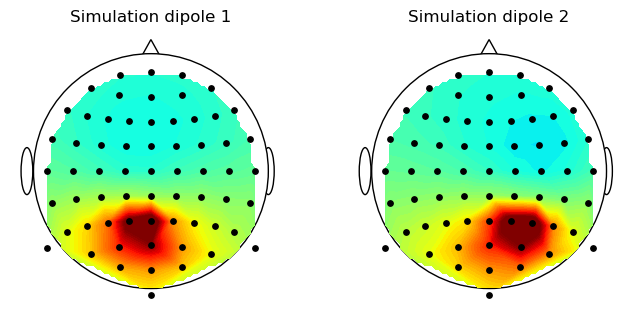

In [6]:
## dipole locations

dipoleLoc1 = 108
dipoleLoc2 = 134

_,axs = plt.subplots(1,2,figsize=(8,5))
topoplotIndie(-lf['Gain'][:,0,dipoleLoc1], EEG['chanlocs'], 'Simulation dipole 1', axs[0])
topoplotIndie(-lf['Gain'][:,0,dipoleLoc2], EEG['chanlocs'], 'Simulation dipole 2', axs[1])


In [7]:
## insert activity waveforms into dipole data

# frequencies of the two dipoles
freq1 = 15
freq2 = 10

# time point of "stimulus" onset
tidx = np.argmin( np.abs(EEG['times']-np.mean(EEG['times'])) )

# the "innards" of the sine function
omega1 = 2*np.pi*freq1*EEG['times'][tidx:]
omega2 = 2*np.pi*freq2*EEG['times'][tidx:]

lfsize = np.shape(lf['Gain'])

# loop over trials
for ti in range(EEG['trials']):
    
    # source waveforms (sine waves with random phase)
    swave1 = np.sin( omega1 + np.random.rand(1)*2*np.pi )
    swave2 = np.sin( omega2 + np.random.rand(1)*2*np.pi )
    
    dipole_data = np.random.randn(EEG['pnts'],lfsize[2])/5
    dipole_data[tidx:,dipoleLoc1] += swave1
    dipole_data[tidx:,dipoleLoc2] += swave2
    
    # project to scalp
    EEG['data'][:,:,ti] = ( dipole_data@lf['Gain'][:,0,:].T ).T



In [8]:
## GED for spatial filter

covPre = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )
covPst = np.zeros( (int(EEG['nbchan']),int(EEG['nbchan'])) )


# covariance matrices per trial
for ti in range(int(EEG['trials'])):
    
    # "prestim" covariance
    tdat = EEG['data'][:,:tidx,ti]
    for ci in range(int(EEG['nbchan'])):
        tdat[ci,:] -= np.mean(tdat[ci,:])
    covPre += (tdat@tdat.T) / EEG['pnts']
    
    
    # "post-stim" covariance
    tdat = EEG['data'][:,tidx:,ti]
    for ci in range(int(EEG['nbchan'])):
        tdat[ci,:] -= np.mean(tdat[ci,:])
    covPst += (tdat@tdat.T) / EEG['pnts']
    

covPre = covPre/ti
covPst = covPst/ti

# GED
evals,evecs = scipy.linalg.eigh(covPst,covPre)
# sort according to eigenvalues
soidx = np.argsort(evals)
soidx = soidx[::-1]
evals = evals[soidx]
evecs = evecs[:,soidx]


#### compute filter forward models and flip sign

# component 1:
map1 = evecs[:,0].T@covPst # get component
idx  = np.argmax(np.abs(map1)) # find max magnitude
map1 = map1*np.sign(map1[idx])  # possible sign flip

# component 2:
map2 = evecs[:,1].T@covPst # get component
idx  = np.argmax(np.abs(map2)) # find max magnitude
map2 = map2*np.sign(map2[idx]) # possible sign flip


### compute component time series (projections)
cdat = np.zeros( (2,int(EEG['pnts']),int(EEG['trials'])) )
for triali in range(int(EEG['trials'])):
    cdat[:,:,triali] = evecs[:,:2].T@EEG['data'][:,:,triali]


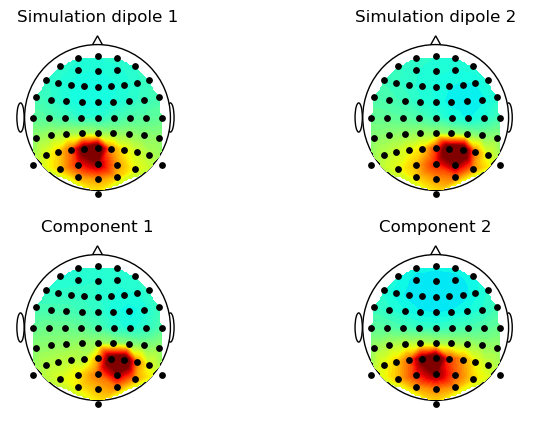

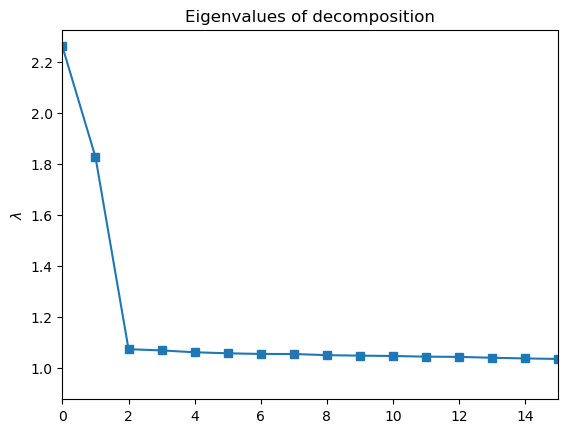

In [9]:
# show the results 

_,axs = plt.subplots(2,2,figsize=(8,5))

topoplotIndie(-lf['Gain'][:,0,dipoleLoc1], EEG['chanlocs'], 'Simulation dipole 1', axs[0,0])
topoplotIndie(-lf['Gain'][:,0,dipoleLoc2], EEG['chanlocs'], 'Simulation dipole 2', axs[0,1])
topoplotIndie(map1,EEG['chanlocs'],'Component 1',axs[1,0])
topoplotIndie(map2,EEG['chanlocs'],'Component 2',axs[1,1])
plt.show()

plt.plot(evals,'s-')
plt.xlim([0,15])
plt.ylabel('$\lambda$')
plt.title('Eigenvalues of decomposition')
plt.show()


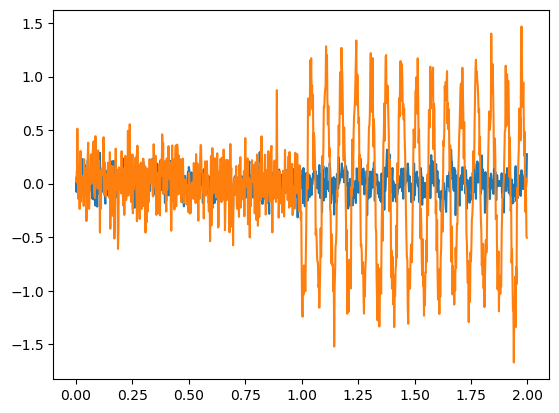

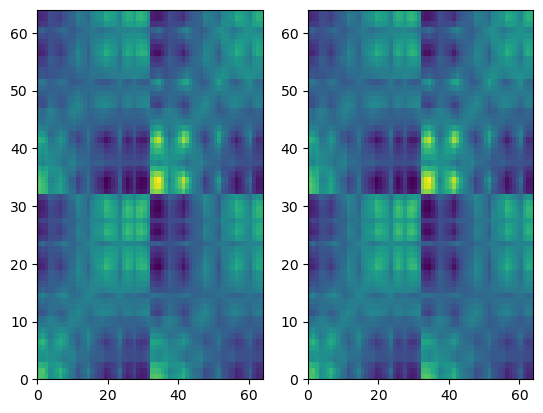

In [10]:
plt.plot(EEG['times'],np.mean(cdat[1,:,:],axis=1))
plt.plot(EEG['times'],dipole_data[:,dipoleLoc1])
plt.show()

plt.subplot(121)
plt.pcolormesh(covPre)
plt.subplot(122)
plt.pcolormesh(covPst)
plt.show()

In [11]:
## standard TF analysis on components

# frequencies in Hz
frex = np.linspace(2,20,20)

# convenient to have component time series data as 2D
comp2d = np.reshape(cdat,(2,int(np.prod(cdat.shape)/2)),order='F')
# comp2d = np.reshape(EEG['data'][[30,46],:,:],(2,int(np.prod(cdat.shape)/2)),order='F')

# initialize time-frequency matrix
ctf = np.zeros( (2,len(frex),EEG['pnts']) )


# loop over frequencies
for fi in range(len(frex)):
    
    # filter data for both components at this frequency
    filtdat,empvals = filterFGx(comp2d,EEG['srate'],frex[fi],4)
    
    # loop over components
    for compi in range(2):
        
        # compute power time series as envelope of Hilbert transform
        tmpm = scipy.signal.hilbert(filtdat[compi,:])
        asig = np.reshape(tmpm ,(EEG['pnts'],EEG['trials']),order='F')
        
        # TF power is trial-average power
        ctf[compi,fi,:] = np.mean( np.abs(asig)**2 ,axis=1)
        

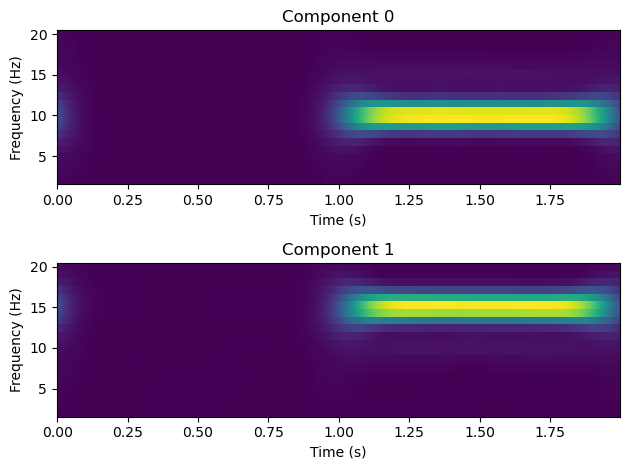

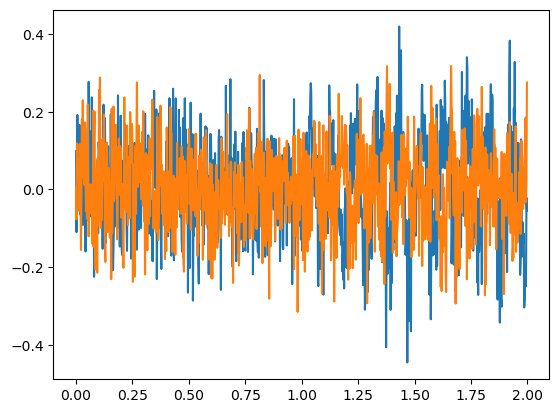

In [12]:
## some plotting

for compi in range(2):
    
    plt.subplot(2,1,compi+1)
    
    plt.pcolormesh(EEG['times'],frex,ctf[compi,:,:])
    plt.title('Component %g' %compi)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


# also show trial-average time-domain series
plt.plot(EEG['times'],np.mean(cdat,axis=2).T)
plt.show()